In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#hide
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

#hide
from fastbook import *

In [3]:
#25407b4f-37fa-4a1c-b0bc-e5f492f77db4
import os
key = os.environ.get('AZURE_SEARCH_KEY', '4d625b02ef37438d8d3f0e2a59e4bd70')

In [ ]:
# PROSOXH https://portal.azure.com/#@konkarageorgosggmail.onmicrosoft.com/resource/subscriptions/a044cafa-19cc-4f21-9ad0-0bd9ba7125c1/resourcegroups/ImageSearch/providers/Microsoft.Bing/accounts/Konstantinos/overview
results = search_images_bing(key, 'car')
ims = results.attrgot('contentUrl')
len(ims)

150

In [4]:
vehicle_types = ['car', 'heavy truck', 'motorbikes']
path = Path('/content/gdrive/MyDrive/fastbook/vehicles')

In [ ]:
if not path.exists():
    path.mkdir()
    for o in vehicle_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [ ]:
# Unlink broken links
fns = get_image_files(path)
failed = verify_images(fns)
failed
failed.map(Path.unlink);

In [ ]:
# notebook hack
??verify_images

In [6]:
vehicles = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [7]:
dls = vehicles.dataloaders(path)

In [ ]:
dls.valid.show_batch(max_n=16, nrows=2)

In [ ]:
vehicles1 = vehicles.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = vehicles1.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

In [ ]:
vehicles1 = vehicles.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = vehicles1.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
vehicles1 = vehicles.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = vehicles1.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In [ ]:
vehicles1 = vehicles.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = vehicles1.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
vehicles1 = vehicles.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = vehicles1.dataloaders(path)

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

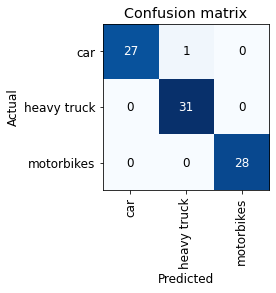

In [9]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

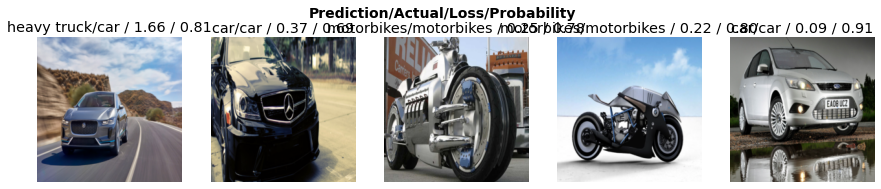

In [10]:
interp.plot_top_losses(5, nrows=1)

In [ ]:
from fastai.vision.widgets import *
cleaner = ImageClassifierCleaner(learn)
cleaner

In [14]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [16]:
# Save models architecture and trained parameters for inference
learn.export()

In [17]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [18]:
learn_inf = load_learner(path/'export.pkl')

In [22]:
link = 'https://ak-content-us-east-public.s3.amazonaws.com/4f931262-4823-4a62-a409-c37544e1bd22'
download_images('/content', urls=[link])

In [ ]:
learn_inf.predict('/content/00000000.jpg')

In [24]:
learn_inf.dls.vocab

['car', 'heavy truck', 'motorbikes']

In [ ]:
# CREATE AN APP IN A NOTEBOOK

In [25]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [26]:
img = PILImage.create(btn_upload.data[-1])

In [29]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [31]:
pred,pred_idx,probs = learn_inf.predict(img)
pred,pred_idx,probs

('car', TensorBase(0), TensorBase([9.8251e-01, 1.7338e-02, 1.5168e-04]))

In [35]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: car; Probability: 0.9825')

In [33]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [34]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [36]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [37]:
#hide_output
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

In [ ]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila